# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

1. **Business Objective**:
- It is to identify key drivers for used car price using **Supervised Regression** in machine learning.
- We will build predictive models where the **Target Variable** is car price, and the **Features** include vehicle attributes such as year, manufacturer, model, condition, mileage, fuel type, transmission, and drive type.
- Using **Feature Importance Analysis** and **Coefficient Interpretation** from multiple regression models, we will quantify the relative impact of each variable on price and identify the most significant predictors through **Cross-Validation** and **Model Evaluation Metrics** like **R² and RMSE**.

3. **Technical Breakdown**

| Category            | Description                                                    |
|---------------------|----------------------------------------------------------------|
| **Problem Type**    | Supervised Learning – Supervised Regression                    |
| **Target Variable** | Car Price                                                      |
| **Features**        | Categorical and numerical vehicle attributes                   |
| **Evaluation**      | Feature importance scores, correlation analysis, model coefficients |
| **Goal**            | Identify which features have strongest predictive power for car price |



### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. **Initial Data Inspection**
   - Load the dataset and examine its data structure
   - Check dataset dimensions (rows, columns)
   - Review column names and data types
   - Sample first few rows to understand data format

2. **Data Quality Assessment**
   - Identify missing values in each column
   - Calculate percentage of missing data per feature
   - Check for duplicate records
   - Examine data types for proper formatting

3. **Statistical Summary**
   - Generate descriptive statistics for numerical variables
   - Analyze categorical variable distributions
   - Identify potential outliers in key numerical fields

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


THRESHOLD = 80  # Remove the feature is if NaN percent is over 80%

In [2]:
# Initial Data Inspection
# Load the dataset and examine its data structure
df = pd.read_csv("data/vehicles.csv", sep=',')

In [3]:
# Set index
if 'id' in df.columns:
    df.set_index('id', drop=True, inplace=True)

# Check dataset dimensions (rows, columns)
print('='*100)
print(f'Shape: {df.shape}')
print(f'Columns: {df.columns}')


# Review column names and data types
print('='*100)
df.info()

# Sample first few rows to understand data format
print('='*100)
df.sample(5, random_state=42)

Shape: (337783, 11)
Columns: Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'transmission', 'drive', 'size'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 337783 entries, 7316814884 to 7301591129
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         337783 non-null  int64  
 1   year          337783 non-null  float64
 2   manufacturer  328719 non-null  object 
 3   model         335284 non-null  object 
 4   condition     209833 non-null  object 
 5   cylinders     197975 non-null  object 
 6   fuel          335779 non-null  object 
 7   odometer      337783 non-null  float64
 8   transmission  336399 non-null  object 
 9   drive         236655 non-null  object 
 10  size          92548 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 30.9+ MB


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size
id,,,,,,,,,,,
7316658716,27899,2021.0,nissan,rogue,NaN,NaN,gas,5718.0,automatic,fwd,NaN
7306596523,5995,2008.0,ford,edge,NaN,NaN,gas,167441.0,automatic,fwd,NaN
7310050829,10997,2008.0,mercedes-benz,ml 350,excellent,4 cylinders,gas,134000.0,automatic,NaN,NaN
7306706059,6995,2008.0,chrysler,town country,good,NaN,gas,166161.0,automatic,rwd,full-size
7316031946,26826,2020.0,ford,ecosport,excellent,NaN,gas,1974.0,automatic,4wd,NaN


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

1. **Integrity and Data Cleaning**
   - Handle missing values through imputation or removal
   - Remove duplicate records
   - Address inconsistent formatting in categorical variables
   - Fix data type mismatches

2. **Outlier Treatment**
   - Identify and handle extreme values in numerical features
   - Remove or cap unrealistic prices and odometer readings
   - Treat outliers in key numerical variables

3. **Feature Engineering**
   - Create derived features (vehicle age from year)
   - Generate categorical aggregations (luxury brand flags)
   - Create interaction terms between important features
   - Simplify complex categorical variables

4. **Categorical Variable Processing**
   - Handle high-cardinality categorical features
   - Encode categorical variables (one-hot, label encoding)
   - Consolidate rare categories into "other" groups

5. **Data Transformations**
   - Apply logarithmic transformations to skewed numerical features
   - Scale numerical features for model compatibility
   - Normalize features where appropriate

6. **Feature Selection**
   - Remove low-variance and highly correlated features
   - Select features based on business relevance and predictive power
   - Create final feature set for modeling

This comprehensive preparation process ensures our dataset is clean, well-structured, and optimized for building accurate predictive models while maintaining data integrity and business relevance.

In [4]:
# Integrity and Data Cleaning

# Drop some featurs which are not related with price
for feature in ['region', 'VIN', 'paint_color', 'state', 'title_status', 'type']:
    if feature in df.columns:
        df.drop([feature], inplace=True, axis=1)

# Identify missing values in each column, calculate percentage of missing data per feature
missing_percent = df.isnull().sum().div(len(df)).mul(100)
cols_to_drop = missing_percent[missing_percent > THRESHOLD].index.tolist()

if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)


# Drop DataFrame with duplicate rows removed
df.drop_duplicates()

# Examine data types for proper formatting
print(df.dtypes)

# Statistical summary for all including numeric datatype and all types
df.describe(include='all')

# Descriptive Statistics for Numerical Variables
df.select_dtypes(include='number').describe()

price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
transmission     object
drive            object
size             object
dtype: object


,price,year,odometer
count,337783.000000,337783.000000,337783.000000
mean,19343.697593,2012.851191,91579.021224
std,13004.688869,4.957901,57913.601721
min,1003.000000,2000.000000,1001.000000
25%,8495.000000,2009.000000,40319.000000
50%,16590.000000,2014.000000,88000.000000
75%,27995.000000,2017.000000,133999.000000
max,64999.000000,2022.000000,249961.000000


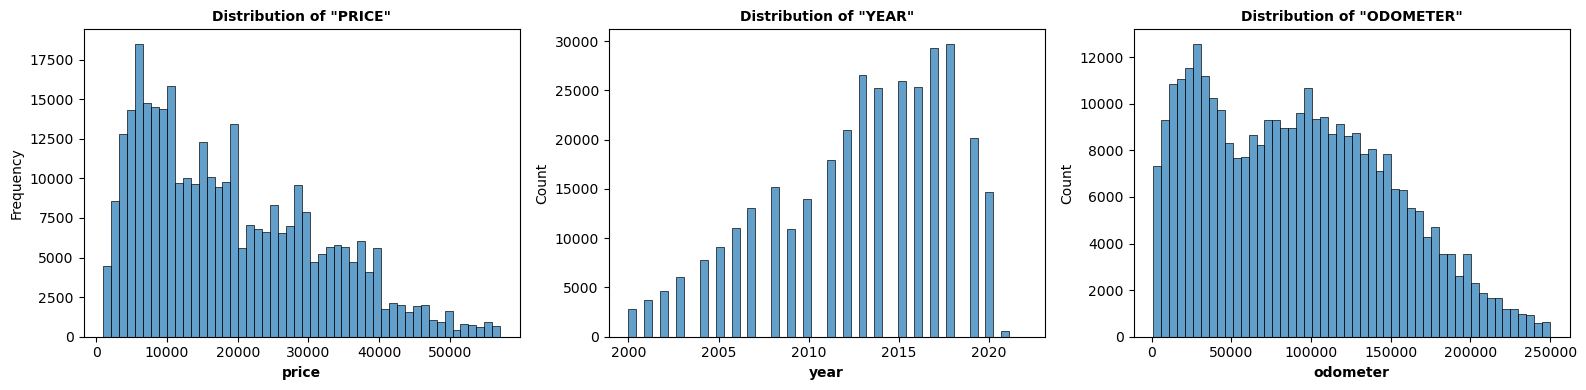

Shape: (334752, 11)


In [5]:
# Outlier Treatment
df = df[(df['price'] > 500) & (df['price'] < 100000)]
df = df[(df['odometer'] > 500) & (df['odometer'] < 250000)]
df = df[(df['year'] >= 2000) & (df['year'] <= 2025)]
# df.to_csv('data/vehicles.csv')

num_cols = df.select_dtypes(include='number').columns

fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 4))
ax = axes.flatten()

for i, c in enumerate(num_cols):
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[c] >= lower_bound) & (df[c] <= upper_bound)]
    sns.histplot(df[c].dropna(), bins=50, edgecolor='black', alpha=0.7, ax=ax[i])
    # ax[i].hist(df[c].dropna(), bins=50, edgecolor='black', alpha=0.7)
    ax[i].set_title(f'Distribution of "{c.upper()}"', fontsize=10, fontweight='bold')
    ax[i].set_xlabel(f'{c}', fontweight='bold')

ax[0].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
print(f'Shape: {df.shape}')


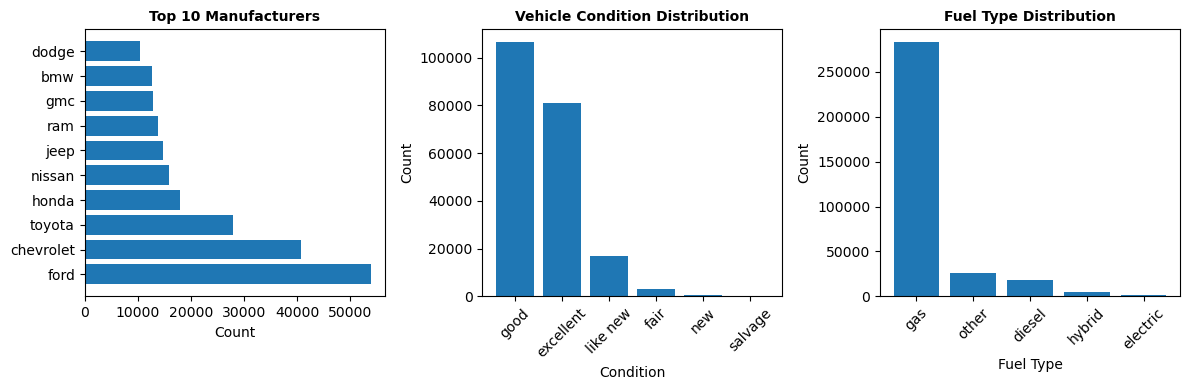

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes.flatten()
# Top manufacturers
top_manufacturers = df['manufacturer'].value_counts().head(10)
ax[0].barh(top_manufacturers.index, top_manufacturers.values)
ax[0].set_title('Top 10 Manufacturers', fontsize=10, fontweight='bold')
ax[0].set_xlabel('Count')

# Condition distribution
condition_counts = df['condition'].value_counts()
ax[1].bar(condition_counts.index, condition_counts.values)
ax[1].set_title('Vehicle Condition Distribution', fontsize=10, fontweight='bold')
ax[1].set_xlabel('Condition')
ax[1].set_ylabel('Count')
ax[1].tick_params(axis='x', rotation=45)

# Fuel type distribution
fuel_counts = df['fuel'].value_counts().head(8)
ax[2].bar(fuel_counts.index, fuel_counts.values)
ax[2].set_title('Fuel Type Distribution', fontsize=10, fontweight='bold')
ax[2].set_xlabel('Fuel Type')
ax[2].set_ylabel('Count')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

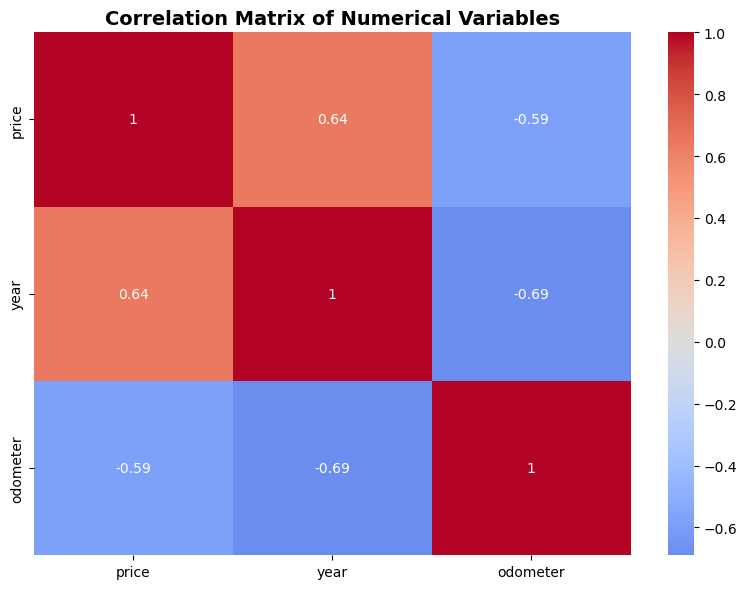

In [7]:
# 2. Correlation heatmap for numerical variables
numerical_cols = ['price', 'year', 'odometer']
plt.figure(figsize=(8, 6))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
# Clean data
categorical_cols = df.select_dtypes(exclude='number').columns
df[categorical_cols] = df[categorical_cols].fillna('unknown')  # inplace=True return a copy only
print(f"After handling missing values: {df.shape}")
df.isnull().sum()

After handling missing values: (334752, 11)


price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
size            0
dtype: int64

In [9]:
# Feature Engineering and check the feature
df['year'] = df['year'].astype(int)

df['manufacturer'] = df['manufacturer'].str.replace(' ', '-', regex=False)
df['odometer'] = df['odometer'].astype(int)

df['cylinders'] = df['cylinders'].str.replace(' cylinders', '', regex=False)
df['cylinders'] = df['cylinders'].str.replace('other', 'unknown')

for c in df.columns:
    print('='*100)
    print(df[c].value_counts())

print('='*100)
print(f'Shape: {df.shape}')

price
7995     2981
6995     2964
9995     2744
8995     2710
29990    2685
         ... 
20887       1
22383       1
17455       1
37121       1
25212       1
Name: count, Length: 13129, dtype: int64
year
2018    29709
2017    29255
2013    26562
2015    25950
2016    25329
2014    25291
2012    21016
2019    20152
2011    17891
2008    15212
2020    14656
2010    13934
2007    13102
2006    11021
2009    10937
2005     9134
2004     7775
2003     6064
2002     4653
2001     3693
2000     2860
2021      544
2022       12
Name: count, dtype: int64
manufacturer
ford               53845
chevrolet          40756
toyota             27918
honda              17950
nissan             15895
jeep               14745
ram                13899
gmc                12857
bmw                12619
dodge              10343
unknown             8912
hyundai             8803
mercedes-benz       8720
subaru              8356
volkswagen          7726
lexus               7185
kia                 7045
audi    

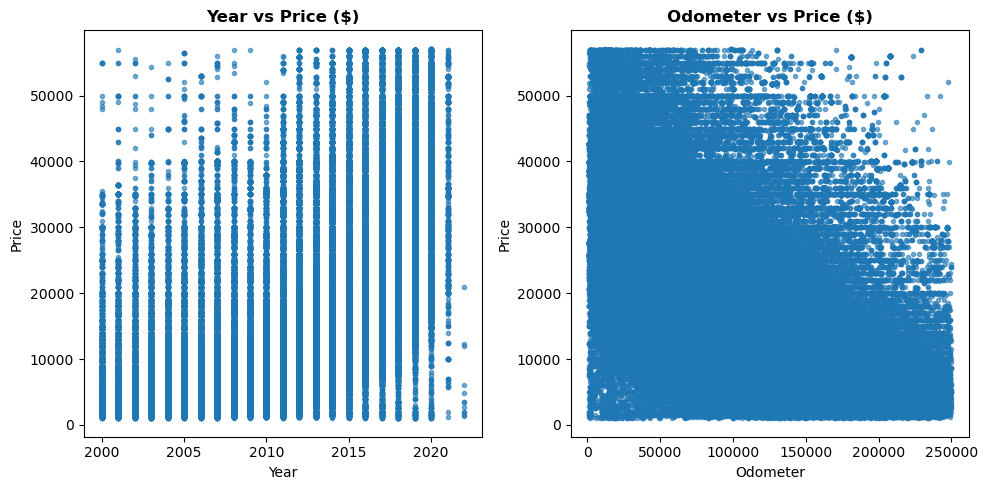

In [10]:
# Visualize new featreus, such as year vs price, odemeter vs price

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(x=df['year'], y=df['price'], alpha=0.6, marker='.')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Price')
axes[0].set_title('Year vs Price ($)', fontweight='bold')

axes[1].scatter(x=df['odometer'], y=df['price'], alpha=0.6, marker='.')
axes[1].set_xlabel('Odometer')
axes[1].set_ylabel('Price')
axes[1].set_title('Odometer vs Price ($)', fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
# Prepare final data for modeling 

# Select features for modeling
base_features = ['year', 'odometer']

# Categorical features to encode
categorical_features = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type']

# Create dummy variables
df_model = df.copy()
features = base_features.copy()

# Extend the features via categorical features
for feature in categorical_features:
    if feature in df_model.columns:
        # Get top 10 categories to avoid too many dummy variables
        top_categories = df_model[feature].value_counts().head(10).index
        df_model[feature] = df_model[feature].apply(lambda x: x if x in top_categories else 'other')

        dummies = pd.get_dummies(df_model[feature], prefix=feature)
        df_model = pd.concat([df_model, dummies], axis=1)
        features.extend(dummies.columns.tolist())

print(f'Total Features after encoding: {len(features)}')
print(f'Final dataset shape: {df_model.shape}')

Total Features after encoding: 58
Final dataset shape: (334752, 67)


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Regression Model Development Strategy
1. **Train-Test Split**
   - Split data into training and testing sets
   - Ensure proper stratification if needed
   - Preserve data distribution across splits
    
2. **Model Selection**
   - Implement multiple regression algorithms for comparison
   - Include **Linear Models**: Linear Regression, Ridge, Lasso
   - Consider ensemble methods for improved performance

3. **Cross-Validation Framework**
   - Implement k-fold cross-validation (k=5)
   - Use stratified sampling if needed
   - Evaluate models using multiple metrics

4. **Hyperparameter Tuning**
   - Grid Search for exhaustive parameter exploration
   - Randomized Search for efficient parameter sampling

In [12]:
# Prepare X and y
X = df_model[features]
y = df_model['price']

# Handle any remaining missing values
X = X.fillna(0)

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (267801, 58)
Test set: (66951, 58)


In [14]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
}
cv_results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_results[name] = {
        'mean_r2': cv_scores.mean(),
        'std_r2': cv_scores.std()
    }
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Linear Regression: 0.7054 (+/- 0.0036)
Ridge Regression: 0.7054 (+/- 0.0036)


In [15]:
# Hyperparameter tuning for the best model
def tune_best_model(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV"""
    
    # Based on CV results, Ridge Regression may have good result
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100]
    }
    
    # Create Ridge model
    ridge = Ridge(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(
        ridge, 
        param_grid, 
        cv=5, 
        scoring='r2', 
        n_jobs=-1, 
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


# Perform hyperparameter tuning
grid_search = tune_best_model(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'alpha': 100}
Best cross-validation score: 0.7054


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

1. **Evaluation Metrics**
   - Primary: R² (coefficient of determination)
   - Secondary: RMSE (root mean squared error)
   - Additional: MAE, MAPE for comprehensive assessment

2. **Model Interpretation**
   - Analyze feature importance scores
   - Interpret coefficients for linear models
   - Validate business relevance of key drivers

3. **Model Validation**
   - Compare cross-validation performance across models
   - Evaluate on held-out test set
   - Assess model robustness and generalization



In [16]:
def evaluate_final_model(grid_search, X_test, y_test):
    """Final Evaluation Model """
    best_model = grid_search[0]

    y_pred = best_model.predict(X_test)
    
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Best Parameters: {grid_search[1]}")
    print(f"Best CV Score: {grid_search[2]:.4f}")
    print(f"Test R² Score: {test_r2:.4f}")
    print(f"Test RMSE: ${test_rmse:,.2f}")
    print(f"Test MAE: ${test_mae:,.2f}")
    print(f"Average car price: ${y_test.mean():,.2f}")
    print(f"RMSE as % of average price: {(test_rmse / y_test.mean()) * 100:.2f}%")
    
    return best_model, y_pred

best_model, y_pred = evaluate_final_model(grid_search, X_test_scaled, y_test)

Best Parameters: {'alpha': 100}
Best CV Score: 0.7054
Test R² Score: 0.7023
Test RMSE: $6,781.15
Test MAE: $5,095.66
Average car price: $19,003.50
RMSE as % of average price: 35.68%


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

###  Top 5 Price Drivers

#### 1. **Vehicle Year** (+$5195)
- **Strongest positive impact** on price
- **Action**: Prioritize newer vehicles (0-3 years old)

#### 2. **Odometer Reading** (-$3714)  
- **Strongest negative impact** on price
- **Action**: Focus on low-mileage vehicles (<50,000 miles)

#### 3. **Diesel Engine** (+$2177)
- **Significant premium** for diesel vehicles
- **Action**: Target diesel models, especially trucks & SUVs

#### 4. **Front-Wheel Drive** (-$1291)
- **Value reduction** compared to 4WD/AWD
- **Action**: 4WD vehicles command premium pricing

#### 5. **Cylinder Count**
- **4-cylinder**: Negative impact (-\$1285)
- **8-cylinder**: Positive impact (+\$1193)
- **Action**: Balance inventory based on local demand

### Key Business Recommendations

#### **Prioritize These Features:**
- **Newer vehicles** (highest impact on price)
- **Low mileage** (critical for valuation)
- **Diesel engines** (premium pricing)
- **4WD/AWD systems** (market preference)
- **8-cylinder engines** (performance demand)

#### **Be Cautious With:**
- High-mileage vehicles
- Front-wheel drive only
- 4-cylinder economy cars
- Hatchback body styles

#### **Pricing Strategy:**
- Use model for **baseline pricing**
- Adjust for **feature premiums/discounts**
- Focus on **high-impact characteristics**
- Regular **model updates** for market changes

**Bottom Line**: Focus on **newer, low-mileage vehicles** with **diesel engines** and **4WD** for maximum profitability.\
Use the model to identify pricing opportunities and optimize inventory mix.

